In [ ]:
!pip install onnx
!pip install onnxscript
!pip install onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 593.5/593.5 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 12.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
import onnx
import onnxruntime
from onnxruntime import quantization
import os
from onnxruntime.quantization import QuantFormat, QuantType, quantize_static, CalibrationDataReader
from PIL import Image
import time
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model_fp32_path = '/content/drive/MyDrive/GDNet_Quantization/ONNX_Files/model_gdnet.onnx'
model_prep_path = '/content/drive/MyDrive/GDNet_Quantization/ONNX_Files/model_gdnet-infer.onnx'

In [ ]:
session = onnxruntime.InferenceSession(model_prep_path, None)
(batch, _, height, width) = session.get_inputs()[0].shape
print(batch,height, width)
session.get_inputs()[0].name

1 416 416


'input.1'

In [ ]:
def _preprocess_images(images_folder: str, height: int, width: int, size_limit=0):
    """
    Loads a batch of images and preprocess them
    parameter images_folder: path to folder storing images
    parameter height: image height in pixels
    parameter width: image width in pixels
    parameter size_limit: number of images to load. Default is 0 which means all images are picked.
    return: list of matrices characterizing multiple images
    """
    image_names = os.listdir(images_folder)
    if size_limit > 0 and len(image_names) >= size_limit:
        batch_filenames = [image_names[i] for i in range(size_limit)]
    else:
        batch_filenames = image_names
    unconcatenated_batch_data = []

    for image_name in batch_filenames:
        image_filepath = images_folder + "/" + image_name
        pillow_img = Image.new("RGB", (width, height))
        pillow_img.paste(Image.open(image_filepath).resize((384, 384)))
        input_data = np.float32(pillow_img) - np.array(
            [123.68, 116.78, 103.94], dtype=np.float32
        )
        nhwc_data = np.expand_dims(input_data, axis=0)
        nchw_data = nhwc_data.transpose(0, 3, 1, 2)  # ONNX Runtime standard
        unconcatenated_batch_data.append(nchw_data)
    batch_data = np.concatenate(
        np.expand_dims(unconcatenated_batch_data, axis=0), axis=0
    )
    return batch_data


class ResNet50DataReader(CalibrationDataReader):
    def __init__(self, calibration_image_folder: str, model_path: str):
        self.enum_data = None

        # Use inference session to get input shape.
        session = onnxruntime.InferenceSession(model_path, None)
        (_, _, height, width) = session.get_inputs()[0].shape

        # Convert image to input data
        self.nhwc_data_list = _preprocess_images(
            calibration_image_folder, height, width, size_limit=5
        )
        self.input_name = session.get_inputs()[0].name
        self.datasize = len(self.nhwc_data_list)

    def get_next(self):
        if self.enum_data is None:
            self.enum_data = iter(
                [{self.input_name: nhwc_data} for nhwc_data in self.nhwc_data_list]
            )
        return next(self.enum_data, None)

    def rewind(self):
        self.enum_data = None

In [ ]:
dr = ResNet50DataReader("/content/drive/MyDrive/GDNet_Quantization/GDNet_Images/", model_prep_path)

In [ ]:
quantized_model_path = '/content/drive/MyDrive/GDNet_Quantization/ONNX_Files/model_gdnet.quant.onnx'
#quantized_model_path = '/content/drive/MyDrive/GDNet_Quantization/ONNX_Files/model_gdnet.onnx'
#quantize_static(model_prep_path, output_model_path, dr, quant_format=QuantFormat.QDQ, per_channel=False,weight_type=QuantType.QInt8,)
#print("Calibrated and quantized model saved.")

In [ ]:
def benchmark(model_path):
    session = onnxruntime.InferenceSession(model_path)
    input_name = session.get_inputs()[0].name

    total = 0.0
    runs = 10
    input_data = np.zeros((1, 3, 416, 416), np.float32)
    # Warming up
    _ = session.run([], {input_name: input_data})
    for i in range(runs):
        start = time.perf_counter()
        _ = session.run([], {input_name: input_data})
        end = (time.perf_counter() - start) * 1000
        total += end
        print(f"{end:.2f}ms")
    total /= runs
    print(f"Avg: {total:.2f}ms")

In [ ]:
print("benchmarking fp32 model...")
benchmark(model_fp32_path)

print("benchmarking int8 model...")
benchmark(quantized_model_path)

benchmarking fp32 model...
4303.33ms
5253.14ms
3932.78ms
4044.47ms
5573.14ms
3965.22ms
3977.14ms
5566.76ms
4445.56ms
3925.45ms
Avg: 4498.70ms
benchmarking int8 model...
4056.89ms
5264.12ms
4242.09ms
3925.25ms
4829.91ms
4812.97ms
5049.10ms
5183.51ms
5661.56ms
4200.36ms
Avg: 4722.58ms


[1, 3, 416, 416]
(1, 1, 416, 416)
[[254 253 253 ... 230 225 220]
 [254 254 253 ... 228 223 218]
 [254 254 253 ... 227 221 215]
 ...
 [  0   0   0 ...  45  59  76]
 [  0   0   0 ...  25  34  46]
 [  0   0   0 ...  13  19  27]]


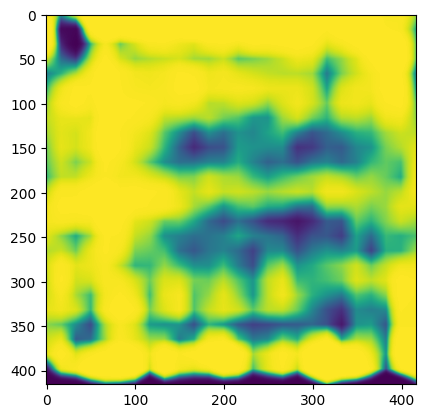

In [ ]:
import torchvision.transforms as transforms

session = onnxruntime.InferenceSession(quantized_model_path)
input_name = session.get_inputs()[0].name
print(session.get_inputs()[0].shape)

image_filepath = '/content/drive/MyDrive/GDNet_Quantization/GDNet_Images/Image4.jpeg'
pillow_img = Image.new("RGB", (width, height))
pillow_img.paste(Image.open(image_filepath).resize((416, 416)))
#plt.imshow(pillow_img)
input_data = np.float32(pillow_img)
nhwc_data = np.expand_dims(input_data, axis=0)
nchw_data = nhwc_data.transpose(0, 3, 1, 2)  # ONNX Runtime standard

output_data = session.run([], {input_name: nchw_data})
print(output_data[0].shape)
img_out_y = output_data[0][0][0]
#plt.imshow(img_out_y)
pred_mask = (img_out_y*255).astype(np.uint8)
print(pred_mask)
plt.imshow(pred_mask)
#plt.imshow(Image.fromarray(pred_mask), cmap='gray',)
plt.show()